In [222]:
from utils import get_conn
from pyathena.util import as_pandas
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import functools as ft
from typing import List, Set
import pandas as pd
from sodapy import Socrata
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.metrics import accuracy_score, precision_score, recall_score
from visdata import summary_table, note_lengths, icd_summary
from utils import tree_to_nx
from icd9.icd9 import ICD9, Node
from colour import Color
import networkx as nx
import matplotlib.pyplot as plt
from constants import PROJ_DIR
import os
from constants import TREE
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import edit_distance
from typing import Dict, Tuple
from torch.utils.data import DataLoader, Dataset

# Summative Visualizations

## Summary Table

In [17]:
summary_table = pd.read_csv("data/full_summary.csv")

In [28]:
summary_table.columns = ["Category"] + list(summary_table.columns[1:])
summary_table = summary_table.set_index("Category")

In [103]:
summary_table

<function visdata.summary_table(conn_func: Callable[[], pyathena.connection.Connection]) -> pandas.core.frame.DataFrame>

In [48]:
icd_table = pd.read_csv("data/icd_summary.csv")

In [49]:
icd_table = icd_table.sort_values("Mimic-iii Counts", ascending=False)
icd_latex = icd_table.to_latex()

In [50]:
icd_table

,Code,Description,Mimic-iii Counts,Nodes in ICD Tree
2,390-459,DISEASES OF THE CIRCULATORY SYSTEM,124782,516
3,240-279,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS",52095,333
0,460-519,DISEASES OF THE RESPIRATORY SYSTEM,40989,277
11,800-999,INJURY AND POISONING,35518,1881
5,520-579,DISEASES OF THE DIGESTIVE SYSTEM,34595,625
1,580-629,DISEASES OF THE GENITOURINARY SYSTEM,32860,471
8,780-799,"SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS",28873,372
6,320-389,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,20397,1633
15,001-139,INFECTIOUS AND PARASITIC DISEASES,19507,1057
13,V10-V19,PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED TO PERSONAL AND FAMILY HISTORY,18358,228


## Category Counts

In [36]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

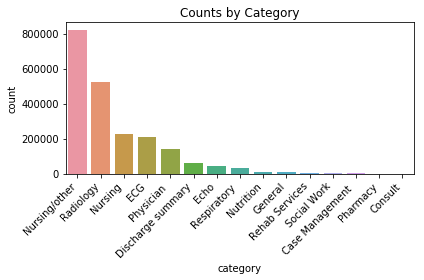

In [39]:
cat_fp = os.path.join(PROJ_DIR, "images", "categories.png")
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distribution of Word Counts in Notes

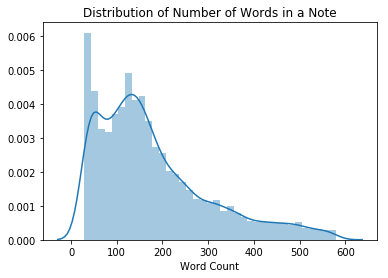

In [376]:
with get_conn() as conn:
    cursor = conn.cursor()
    notes = as_pandas(cursor.execute("select text from mimiciii.noteevents order by RAND() limit 10000;"))["text"]
lens = notes.apply(lambda x: len(x.split()))
no_outliers = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]
ax = sns.distplot(no_outliers)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig("images/word_counts.png")
plt.show()

# ICD Tagging Models

## Read in training/testing data

In [304]:
# one hot encode nodes
def nodes_to_idx(X: List[List[str]], roots: List[str]) -> List[List[int]]:
    return [[1 if r in row else 0 for r in roots] for row in X]

In [296]:
# read in raw data
subdir = "half_data_ids"
lim = 50000
ids = pd.read_csv(os.path.join(subdir, "ids.csv"), squeeze=True, nrows=lim).tolist()
raw_roots = pd.read_csv(os.path.join(subdir, "roots_labels.csv"), squeeze=True, nrows=lim).tolist()
roots = [[s.strip("''") for s in x.strip("[]").split(", ") if len(s.strip("''")) > 0]
         for x in raw_roots]
embeddings = pd.read_csv(os.path.join(subdir, "doc2vec.csv"), header=None, nrows=lim).values

# split data into train/test and expand root list
emb_train, X_test, root_train, y_test = train_test_split(embeddings, roots, test_size=0.3)
X_train = np.array(ft.reduce(lambda acc, n: acc + n,
                             map(lambda n, r: [n] * len(r), emb_train, root_train),
                             []))
y_train = ft.reduce(lambda acc, r: acc + r, root_train, [])

In [301]:
def calc_metrics(pred, true, metric):
    if metric == "acc":
        if len(true) == 0:
            return 1 if len(pred) == 0 else 0
        else:
            return len(set(pred) & set(true)) / len(set(pred) | set(true))
    elif metric == "rec":
        if len(pred) == 0:
            return 1 if len(true) == 0 else 0
        else:
            return len(set(pred) & set(true)) / len(pred)
    elif metric == "prec":
        if len(true) == 0:
            return 1 if len(pred) == 0 else 0
        else:
            return len(set(pred) & set(true)) / len(true)
    elif metric == "f1":
        if len(true) == 0:
            return 1 if len(pred) == 0 else 0
        else:
            return 2 * len(set(pred) & set(true)) / (len(set(true)) + len(set(pred)))
    else:
        raise ValueError("Invalid metric type.")

## Logistic Regression

### Train

In [297]:
# train logistic regression
clf = LogisticRegression(random_state=0, multi_class="ovr", max_iter=10000).fit(X_train, y_train)

In [298]:
# get predictions
probs = clf.predict_proba(X_test)

### Evaluate

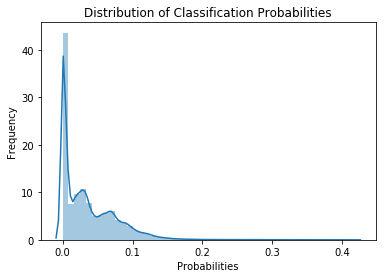

In [372]:
# view distribution of probability predictions
ax = sns.distplot(ft.reduce(lambda a, x: a + x, probs.tolist(), []))
ax.set(xlabel="Probabilities", ylabel="Frequency", title="Distribution of Classification Probabilities")
plt.savefig("images/prob_dists.png")
plt.show()

In [373]:
# get codes per note with probs
un_thresholds = [0.01, 0.05, 0.1, 0.15, 0.2]
y_preds = [[[clf.classes_[i] for i, prob in enumerate(obs) if prob > thresh]
            for obs in probs.tolist()] for thresh in un_thresholds]

In [374]:
metrics = ([[calc_metrics(p, t, met) for p, t in zip(y_pred, y_test)] for y_pred in y_preds]
           for met in ["acc", "rec", "prec", "f1"])
mean_accs, mean_recs, mean_precs, mean_f1s = ([sum(met) / len(met) for met in mets] for mets in metrics)
threshes = un_thresholds * 4
met_labels = ["F1"] * len(mean_f1s) + ["Accuracy"] * len(mean_accs) + ["Recall"] * len(mean_recs) + ["Precision"] * len(mean_precs)
metrics = mean_f1s + mean_accs + mean_recs + mean_precs

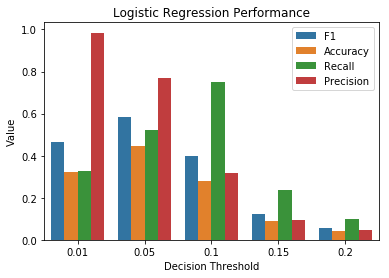

In [375]:
ax = sns.barplot(x=threshes, y=metrics, hue=met_labels)
ax.set(xlabel="Decision Threshold", ylabel="Value", title="Logistic Regression Performance")
plt.savefig("images/logreg.png")
plt.show()

## Feed Forward Neural Network

### Train

In [305]:
class FFNN(nn.Module):
    """A vanilla feed forward neural network with 2 hidden layers and multi label output."""

    def __init__(self, n_feat, h1_size, h2_size, n_cat):
        super(FFNN, self).__init__()
        # define layers
        self.h1= nn.Linear(n_feat, h1_size)
        self.h2 = nn.Linear(h1_size, h2_size)
        self.out = nn.Linear(h2_size, n_cat)
        self.sig = nn.Sigmoid()

    def forward(self, X):
        l1 = F.relu(self.h1(X))
        l2 = F.relu(self.h2(l1))
        output = self.sig(self.out(l2))
        return output
    
    def run_train(self, trainloader: DataLoader, n_epochs: int) -> None:
        """Train network on training set."""
        self.train()  # set model to train mode
        loss_fn = nn.BCELoss(reduction='mean')
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        # loop over the dataset for each epoch
        print("Training mlp .....")
        for i in range(n_epochs):
            print(f"\tEpoch {i}:", end=" ")
            for data in trainloader:
                # extracts features/labels from loader
                feats, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # retrieve outputs
                outputs = self.forward(feats)
                
                # determine loss and backprop
                loss = loss_fn(outputs, labels)
                loss.backward()  # calculate gradients
                optimizer.step()  # update parameters
                
            print(f"loss = {loss}")
        print("done.")

In [306]:
class ICDDataset(Dataset):
    """Implementation of PyTorch dataset."""

    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        """Initialize class variables."""
        self.X = X
        self.y = y

    def __len__(self) -> int:
        """Return the length of this dataset."""
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Get the features and label at the given index."""
        xi: torch.FloatTensor = torch.FloatTensor(self.X[idx])
        yi: torch.FloatTensor = torch.FloatTensor(self.y[idx])
        return xi, yi

In [307]:
# convert arrays of codes to one hot representations
top_level_roots = [c.code for c in TREE.children]
one_hot_y_train = nodes_to_idx(root_train, top_level_roots)
one_hot_y_test = nodes_to_idx(y_test, top_level_roots)

In [308]:
# declare train and test loaders
BATCH_SIZE = 64
trainset = ICDDataset(emb_train, np.array(one_hot_y_train))
testset = ICDDataset(X_test, np.array(one_hot_y_test))
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, shuffle=False)

In [309]:
# train MLP
n_epochs = 30
n_feats = trainset.X.shape[1]
n_cats = len(top_level_roots)
ffnn = FFNN(n_feats, 40, 40, n_cats)
ffnn.run_train(trainloader, n_epochs)

Training mlp .....
	Epoch 0: loss = 0.19159482419490814
	Epoch 1: loss = 0.19069665670394897
	Epoch 2: loss = 0.18415074050426483
	Epoch 3: loss = 0.18717080354690552
	Epoch 4: loss = 0.16446180641651154
	Epoch 5: loss = 0.15795670449733734
	Epoch 6: loss = 0.1792030930519104
	Epoch 7: loss = 0.164264515042305
	Epoch 8: loss = 0.1650623381137848
	Epoch 9: loss = 0.16272714734077454
	Epoch 10: loss = 0.15774911642074585
	Epoch 11: loss = 0.16662897169589996
	Epoch 12: loss = 0.1655271351337433
	Epoch 13: loss = 0.1626024693250656
	Epoch 14: loss = 0.1625359207391739
	Epoch 15: loss = 0.15344464778900146
	Epoch 16: loss = 0.160551980137825
	Epoch 17: loss = 0.15519975125789642
	Epoch 18: loss = 0.1647915244102478
	Epoch 19: loss = 0.15099772810935974
	Epoch 20: loss = 0.1670033186674118
	Epoch 21: loss = 0.16121834516525269
	Epoch 22: loss = 0.16599811613559723
	Epoch 23: loss = 0.15041394531726837
	Epoch 24: loss = 0.16294118762016296
	Epoch 25: loss = 0.1595475673675537
	Epoch 26: loss

### Evaluate

In [310]:
# evaluate ffnn
nn_preds = ffnn(torch.FloatTensor(X_test)).detach().numpy()

In [311]:
# get codes per note with probs
un_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
y_preds = [[[top_level_roots[i] for i, prob in enumerate(obs) if prob > thresh]
            for obs in nn_preds.tolist()] for thresh in un_thresholds]

In [312]:
# get evaluation metrics
metrics = ([[calc_metrics(p, t, met) for p, t in zip(y_pred, y_test)] for y_pred in y_preds]
           for met in ["acc", "rec", "prec", "f1"])
mean_accs, mean_recs, mean_precs, mean_f1s = ([sum(met) / len(met) for met in mets] for mets in metrics)
threshes = un_thresholds * 4
met_labels = ["F1"] * len(mean_f1s) + ["Accuracy"] * len(mean_accs) + ["Recall"] * len(mean_recs) + ["Precision"] * len(mean_precs)
metrics = mean_f1s + mean_accs + mean_recs + mean_precs

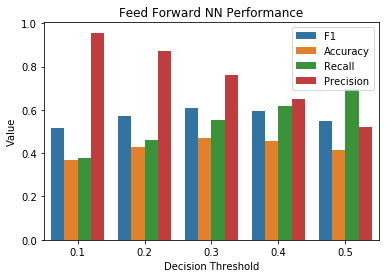

In [371]:
ax = sns.barplot(x=threshes, y=metrics, hue=met_labels)
ax.set_title("Feed Forward NN Performance")
ax.set(xlabel="Decision Threshold", ylabel="Value")
plt.savefig("images/ffnn.png")
plt.show()

In [334]:
def class_counts(preds, trues, all_roots) -> pd.DataFrame:
    pred_counts = dict(Counter(ft.reduce(lambda acc, x: acc + x, preds, [])))
    true_counts = dict(Counter(ft.reduce(lambda acc, x: acc + x, trues, [])))
    df = pd.DataFrame(data={"root": all_roots})
    df["true"] = df["root"].apply(lambda x: true_counts[x] if x in true_counts.keys() else 0)
    df["pred"] = df["root"].apply(lambda x: pred_counts[x] if x in pred_counts.keys() else 0)
    df = df.set_index("root").sort_values("true", ascending=False)
    return df

In [335]:
counts = class_counts(y_preds[2], y_test, top_level_roots)

# Evaluate by Subsets of Data

## Categories

In [366]:
# read in data
with get_conn() as conn:
    cursor = conn.cursor()
    query = f"""
    SELECT
      row_id as row_id,
      category
    FROM
      mimiciii.noteevents;
    """
    cat_df = as_pandas(cursor.execute(query))

In [358]:
str(ids).replace("[", "(").replace("]", ")")

'(1955808, 128994, 1021040, 1581513, 1336577, 387282, 32327, 724241, 1472083, 719563)'

In [351]:
accs = [calc_metrics(p, t, "acc") for p, t in zip(y_preds[2], y_test)]
cat_df["accs"] = accs

ValueError: Length of values does not match length of index